In [1]:
import sys
import os

parent = os.path.dirname(os.path.realpath('../'))
sys.path.append(parent)

import numpy as np
import scipy
import tqdm
import open3d as o3d
import matplotlib.pyplot as plt
import glob

from core import *
from utils import phantom_builder
from utils import geometry
from utils import utils

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

overwrite_figures = True

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
test_phantom = phantom.Phantom(source_path = None,
            voxel_dims = (0.25e-3,0.25e-3,0.25e-3),
            matrix_dims = (256,256,128),
            baseline = (1500, 1000),
            seed = 5678,)

water = tissue.Tissue(name='water', c=1500, rho=1000, sigma=0, scale=0.001, label=0)
wire = tissue.Tissue(name='wire', c=2400, rho=1500, sigma=0, scale=0.001, label=1)

pos = 0.016
test_phantom.add_tissue(water, mask=np.ones(test_phantom.matrix_dims))

wire_mask = np.zeros(test_phantom.matrix_dims)
for i in range(0,7): # horizontal near
    wire_mask[128,32+i*16,:] = 1
for i in range(0,7): # horizontal far
    wire_mask[192,32+i*32,:] = 1
for i in range(0,10): # vertical left
    wire_mask[96+16*i,96,:] = 1
for i in range(0,5): # vertical left
    wire_mask[96+32*i,160,:] = 1
test_phantom.add_tissue(wire, mask=wire_mask)
    
test_phantom.set_default_tissue('water')
test = test_phantom.get_complete()

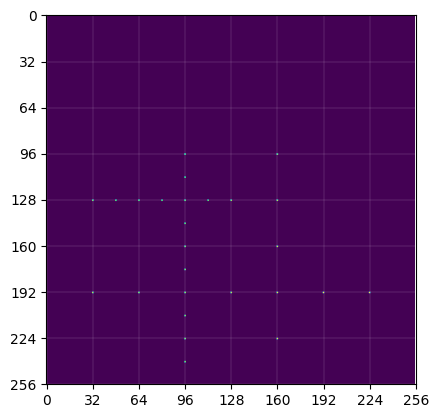

In [3]:
plt.imshow(test[0,:,:,test_phantom.matrix_dims[2]//2])

plt.gca().set_xticks(np.linspace(0, test_phantom.matrix_dims[1],9))
plt.gca().set_yticks(np.linspace(0, test_phantom.matrix_dims[0],9))
plt.gca().grid(color='w', linestyle='-', linewidth=0.1)

In [4]:
num_transducers = 3
transducers = [transducer.Planewave(max_frequency=2e6,
                                    elements = 128, 
                                    width = 20e-3,
                                    height =  10e-3,
                                    sensor_sampling_scheme = 'not_centroid', 
                                    sweep = np.pi/4,
                                    ray_num = 5,
                                    imaging_ndims = 2,
                                    focus_elevation = 50e-3,
                                    ) for i in range(num_transducers)]

for t in transducers:
    t.make_sensor_coords(test_phantom.baseline[0])

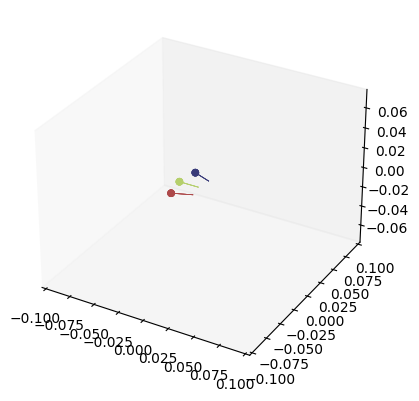

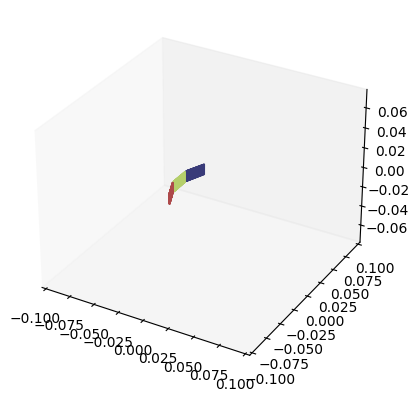

In [5]:
cont_transducer_set = transducer_set.TransducerSet(transducers, seed=8888)
cont_transducer_set.assign_pose(0, geometry.Transform([-np.pi/8,0,0], [-0.021,0.021,0]))
cont_transducer_set.assign_pose(1, geometry.Transform([0,0,0], [-0.025,0,0]))
cont_transducer_set.assign_pose(2, geometry.Transform([np.pi/8,0,0], [-0.021,-0.021,0]))

cont_transducer_set.plot_transducer_fovs(scale=0.1)
cont_transducer_set.plot_transducer_coords(scale=0.1)

In [6]:
extended_sensor = sensor.Sensor(transducer_set=cont_transducer_set, aperture_type='extended_aperture')
tar_sensor = sensor.Sensor(transducer_set=cont_transducer_set, aperture_type='transmit_as_receive')

In [7]:
simprops = simulation.SimProperties(
                grid_size   = (50e-3,55e-3,20e-3),
                PML_size    = (16,8,8),
                PML_alpha   = 2,
                t_end       = 12e-5,           # [s]
                bona        = 6,               # parameter b/a determining degree of nonlinear acoustic effects
                alpha_coeff = 0.5, 	           # [dB/(MHz^y cm)]
                alpha_power = 1.5,
                )

In [8]:
extended_experiment = experiment.Experiment(
                 simulation_path = 'synchronous_aperture_wire',
                 sim_properties  = simprops,
                 phantom         = test_phantom,
                 transducer_set  = cont_transducer_set,
                 sensor          = extended_sensor,
                 nodes           = 1,
                 results         = None,
                 indices         = None,
                 workers         = 2,
                 additional_keys = []
                 )

tar_experiment = experiment.Experiment(
                 simulation_path = 'sequential_aperture_wire',
                 sim_properties  = simprops,
                 phantom         = test_phantom,
                 transducer_set  = cont_transducer_set,
                 sensor          = tar_sensor,
                 nodes           = 1,
                 results         = None,
                 indices         = None,
                 workers         = 2,
                 additional_keys = []
                 )

extended_experiment.save()
tar_experiment.save()

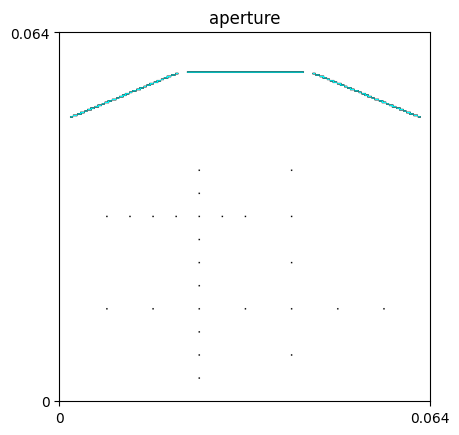

In [9]:
gm = extended_experiment.visualize_sensor_mask(index=[slice(0, -1, 1), slice(0, -1, 1), test_phantom.matrix_dims[2]//2+1])
plt.gca().set_title('aperture')
plt.gca().set_xticks([-1,256])
plt.gca().set_xticklabels(['0','0.064'])
plt.gca().set_yticks([0,256])
plt.gca().set_yticklabels(['0.064','0'])
plt.savefig('wire_phantom.png', dpi=300, bbox_inches="tight")

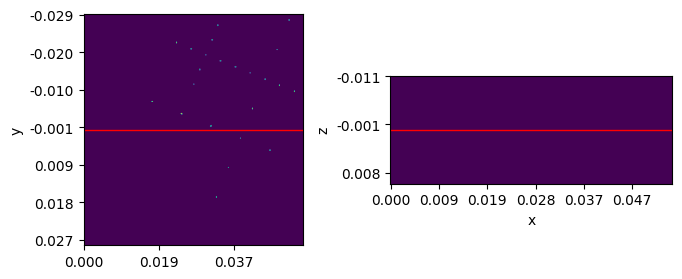

In [10]:
extended_experiment.plot_ray_path(0)

In [11]:
test_experiment = experiment.Experiment.load('sequential_aperture_wire')
test_experiment.run(dry=True)
test_experiment.run(repeat=True)

Number of simulation results (0) is less than the expected number of simulation results (15), are you sure the simulation finished running?
dry run of simulation


100%|██████████| 3/3 [00:00<00:00,  5.64it/s]

running with 2 workers



preparation for sim    0 completed in 11.69 seconds
preparation for sim    1 completed in 11.73 seconds
simulation             0 completed in 23.80 seconds
preparation for sim    2 completed in 11.72 seconds
simulation             1 completed in 23.77 seconds
preparation for sim    3 completed in 11.68 seconds
simulation             2 completed in 23.75 seconds
preparation for sim    4 completed in 12.00 seconds
simulation             3 completed in 24.10 seconds
preparation for sim    5 completed in 12.91 seconds
simulation             4 completed in 24.09 seconds
preparation for sim    6 completed in 11.71 seconds
simulation             5 completed in 23.94 seconds
preparation for sim    7 completed in 11.96 seconds
simulation             6 completed in 24.12 seconds
preparation for sim    8 completed in 11.95 seconds
simulation             7 completed in 24.18 seconds
preparation for sim    9 completed in 11.90 seconds
simulation             8 completed in 24.20 seconds
preparation 

In [12]:
test_experiment = experiment.Experiment.load('synchronous_aperture_wire')
test_experiment.run(dry=True)
test_experiment.run(repeat=True)

Number of simulation results (0) is less than the expected number of simulation results (15), are you sure the simulation finished running?
dry run of simulation


100%|██████████| 3/3 [00:00<00:00,  5.97it/s]

running with 2 workers



preparation for sim    0 completed in 11.77 seconds
preparation for sim    1 completed in 12.21 seconds
simulation             0 completed in 24.63 seconds
preparation for sim    2 completed in 11.77 seconds
simulation             1 completed in 24.15 seconds
preparation for sim    3 completed in 11.86 seconds
simulation             2 completed in 24.26 seconds
preparation for sim    4 completed in 11.91 seconds
simulation             3 completed in 24.43 seconds
preparation for sim    5 completed in 12.16 seconds
simulation             4 completed in 24.50 seconds
preparation for sim    6 completed in 12.08 seconds
simulation             5 completed in 24.52 seconds
preparation for sim    7 completed in 11.99 seconds
simulation             6 completed in 24.45 seconds
preparation for sim    8 completed in 11.94 seconds
simulation             7 completed in 24.42 seconds
preparation for sim    9 completed in 13.98 seconds
simulation             8 completed in 24.49 seconds
preparation 

# Reconstruction

In [13]:
test_experiment = experiment.Experiment.load('sequential_aperture_wire')
test_experiment.run(dry=True)
test_experiment.add_results()
test_reconstruction = reconstruction.Compounding(experiment=test_experiment)

dry run of simulation


100%|██████████| 3/3 [00:00<00:00,  5.52it/s]


In [14]:
images1 = test_reconstruction.compound(workers=1, resolution_multiplier=2, local=True, combine=False)

100%|██████████| 15/15 [00:00<00:00, 390773.66it/s]


In [15]:
image1 = np.sum(images1, axis=0)/len(images1)
image1t1 = np.sum(images1[:len(images1)//3], axis=0)/(len(images1)//3)
image1t2 = np.sum(images1[len(images1)//3:2*len(images1)//3], axis=0)/(len(images1)//3)
image1t3 = np.sum(images1[2*len(images1)//3:], axis=0)/(len(images1)//3)


In [16]:
from scipy.interpolate import NearestNDInterpolator
sensor = test_experiment.get_sensor_mask()
x = []
y = []
z = []
for i in tqdm.tqdm(range(sensor.shape[0])):
    for j in range(sensor.shape[1]):
        x.append(i)
        y.append(j)
        z.append(sensor[i,j,:].sum(axis=-1))
X = np.linspace(0, sensor.shape[0], image1.shape[0])
Y = np.linspace(0, sensor.shape[1], image1.shape[1])
X, Y = np.meshgrid(X, Y, indexing='ij')  # 2D grid for interpolation
interp = NearestNDInterpolator(list(zip(x, y)), z)
Z = interp(X, Y)
sensor_mask = Z
sensor_mask3 = sensor_mask.copy()
sensor_mask3[:,114:] = 0
sensor_mask2 = sensor_mask.copy()
sensor_mask2[:,:114] = 0
sensor_mask2[:,228:] = 0
sensor_mask1 = sensor_mask.copy()
sensor_mask1[:,:228] = 0

100%|██████████| 256/256 [00:00<00:00, 2784.61it/s]


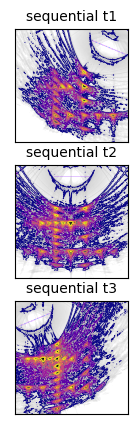

In [17]:
fig, ax = plt.subplots(3,1, figsize=(2.5,5))
contour_cmap = plt.cm.get_cmap('plasma')

psf = 20 * np.log10(image1t1 / 1000000)
image = psf[:,:,psf.shape[2]//2]
im = ax[0].imshow(image, cmap='gray_r', vmin=-100, vmax=-50)
ax[0].imshow(sensor_mask1, cmap='cool_r', alpha=(sensor_mask1>0)*1.0)
CS = ax[0].contour(image, cmap=contour_cmap, linewidths=0.5, levels = [-90,-85,-80,-75,-70,-65,-60])
ax[0].set_title('sequential t1', fontsize=10)

psf = 20 * np.log10(image1t2 / 1000000)
image = psf[:,:,psf.shape[2]//2]
im = ax[1].imshow(image, cmap='gray_r', vmin=-100, vmax=-50)
ax[1].imshow(sensor_mask2, cmap='cool_r', alpha=(sensor_mask2>0)*1.0)
CS = ax[1].contour(image, cmap=contour_cmap, linewidths=0.5, levels = [-90,-85,-80,-75,-70,-65,-60])
ax[1].set_title('sequential t2', fontsize=10)

psf = 20 * np.log10(image1t3 / 1000000)
image = psf[:,:,psf.shape[2]//2]
im = ax[2].imshow(image, cmap='gray_r', vmin=-100, vmax=-50)
ax[2].imshow(sensor_mask3, cmap='cool_r', alpha=(sensor_mask3>0)*1.0)
CS = ax[2].contour(image, cmap=contour_cmap, linewidths=0.5, levels = [-90,-85,-80,-75,-70,-65,-60])
ax[2].set_title('sequential t3', fontsize=10)

# plt.colorbar(im, cax=ax.inset_axes([1.035, 0, 0.04, 1]), label='dB', ticks=[-100,-75,-70,-65,-60,-55,-50,0])
# proxy = [plt.Rectangle((0,0),1,1,fc = pc.get_edgecolor()[0]) for pc in CS.collections]
# plt.legend(proxy[::-1], ['','','','','',''][::-1], frameon=False, handlelength=1, handleheight=0.01, fontsize=10, bbox_to_anchor=(1.138, 0.55), labelspacing = 0.33)
# ax.clabel(CS, inline=True, fontsize=10)

ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[2].set_xticks([])
ax[2].set_yticks([])
if overwrite_figures:
    plt.savefig('sequential_aperture_individual_wire.png', dpi=300, bbox_inches="tight")

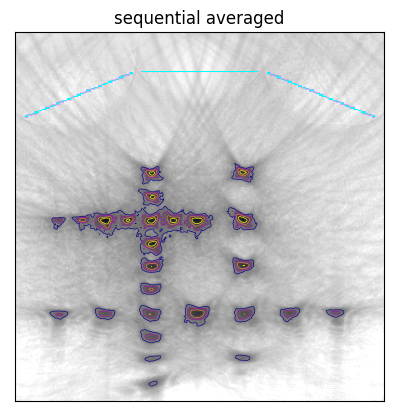

In [46]:
psf = 20 * np.log10(image1 / 1000000)
image = psf[:,:,psf.shape[2]//2]

fig, ax = plt.subplots()
contour_cmap = plt.cm.get_cmap('plasma')

im = ax.imshow(image, cmap='gray_r', vmin=-100, vmax=-50)
ax.imshow(sensor_mask, cmap='cool_r', alpha=(sensor_mask>0)*1.0)
CS = ax.contour(image, cmap=contour_cmap, linewidths=0.5, levels = [-75,-70,-65,-60])

ax.set_title('sequential averaged')

# plt.colorbar(im, cax=ax.inset_axes([1.035, 0, 0.04, 1]), label='dB', ticks=[-100,-75,-70,-65,-60,-55,-50,0])
# proxy = [plt.Rectangle((0,0),1,1,fc = pc.get_edgecolor()[0]) for pc in CS.collections]
# plt.legend(proxy[::-1], ['','','','','',''][::-1], frameon=False, handlelength=1, handleheight=0.01, fontsize=10, bbox_to_anchor=(1.138, 0.55), labelspacing = 0.33)
# ax.clabel(CS, inline=True, fontsize=10)

ax.set_xticks([])
ax.set_yticks([])
if overwrite_figures:
    plt.savefig('sequential_aperture_wire.png', dpi=300, bbox_inches="tight")

In [19]:
test_experiment = experiment.Experiment.load('synchronous_aperture_wire')
test_experiment.run(dry=True)
test_experiment.add_results()
test_reconstruction = reconstruction.Compounding(experiment=test_experiment)

dry run of simulation


100%|██████████| 3/3 [00:00<00:00,  4.88it/s]


In [20]:
images2 = test_reconstruction.compound(workers=1, resolution_multiplier=2, local=True, combine=False)

100%|██████████| 15/15 [00:00<00:00, 416652.72it/s]


In [58]:
image2 = np.sum(images2, axis=0)/len(images2)
image2t1 = np.sum(images2[:len(images2)//3], axis=0)/(len(images2)//3)
image2t2 = np.sum(images2[len(images2)//3:2*len(images2)//3], axis=0)/(len(images2)//3)
image2t3 = np.sum(images2[2*len(images2)//3:], axis=0)/(len(images2)//3)


In [22]:
from scipy.interpolate import NearestNDInterpolator
sensor = test_experiment.get_sensor_mask()
x = []
y = []
z = []
for i in tqdm.tqdm(range(sensor.shape[0])):
    for j in range(sensor.shape[1]):
        x.append(i)
        y.append(j)
        z.append(sensor[i,j,:].sum(axis=-1))
X = np.linspace(0, sensor.shape[0], image1.shape[0])
Y = np.linspace(0, sensor.shape[1], image1.shape[1])
X, Y = np.meshgrid(X, Y, indexing='ij')  # 2D grid for interpolation
interp = NearestNDInterpolator(list(zip(x, y)), z)
Z = interp(X, Y)
sensor_mask = Z
sensor_mask3 = sensor_mask.copy()
sensor_mask3[:,114:] = 0
sensor_mask2 = sensor_mask.copy()
sensor_mask2[:,:114] = 0
sensor_mask2[:,228:] = 0
sensor_mask1 = sensor_mask.copy()
sensor_mask1[:,:228] = 0

100%|██████████| 256/256 [00:00<00:00, 2847.96it/s]


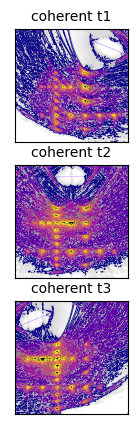

In [23]:
fig, ax = plt.subplots(3,1, figsize=(2.5,5))
contour_cmap = plt.cm.get_cmap('plasma')

psf = 20 * np.log10(image2t1 / 1000000)
image = psf[:,:,psf.shape[2]//2]
im = ax[0].imshow(image, cmap='gray_r', vmin=-100, vmax=-50)
ax[0].imshow(sensor_mask1, cmap='cool_r', alpha=(sensor_mask1>0)*1.0)
CS = ax[0].contour(image, cmap=contour_cmap, linewidths=0.5, levels = [-90,-85,-80,-75,-70,-65,-60])
ax[0].set_title('synchronous t1', fontsize=10)

psf = 20 * np.log10(image2t2 / 1000000)
image = psf[:,:,psf.shape[2]//2]
im = ax[1].imshow(image, cmap='gray_r', vmin=-100, vmax=-50)
ax[1].imshow(sensor_mask2, cmap='cool_r', alpha=(sensor_mask2>0)*1.0)
CS = ax[1].contour(image, cmap=contour_cmap, linewidths=0.5, levels = [-90,-85,-80,-75,-70,-65,-60])
ax[1].set_title('synchronous t2', fontsize=10)

psf = 20 * np.log10(image2t3 / 1000000)
image = psf[:,:,psf.shape[2]//2]
im = ax[2].imshow(image, cmap='gray_r', vmin=-100, vmax=-50)
ax[2].imshow(sensor_mask3, cmap='cool_r', alpha=(sensor_mask3>0)*1.0)
CS = ax[2].contour(image, cmap=contour_cmap, linewidths=0.5, levels = [-90,-85,-80,-75,-70,-65,-60])
ax[2].set_title('synchronous t3', fontsize=10)

# plt.colorbar(im, cax=ax.inset_axes([1.035, 0, 0.04, 1]), label='dB', ticks=[-100,-75,-70,-65,-60,-55,-50,0])
# proxy = [plt.Rectangle((0,0),1,1,fc = pc.get_edgecolor()[0]) for pc in CS.collections]
# plt.legend(proxy[::-1], ['','','','','',''][::-1], frameon=False, handlelength=1, handleheight=0.01, fontsize=10, bbox_to_anchor=(1.138, 0.55), labelspacing = 0.33)
# ax.clabel(CS, inline=True, fontsize=10)

ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[2].set_xticks([])
ax[2].set_yticks([])
if overwrite_figures:
    plt.savefig('synchronous_aperture_individual_wire.png', dpi=300, bbox_inches="tight")

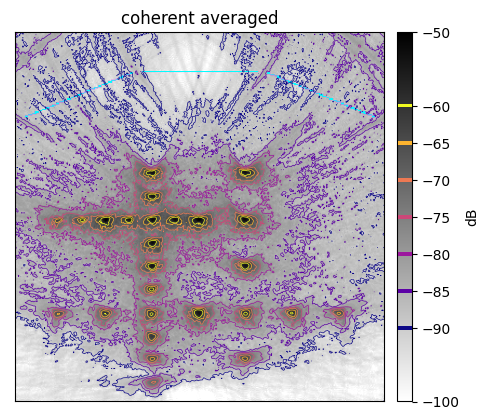

In [60]:
psf = 20 * np.log10(image2 / 1000000)
image = psf[:,:,psf.shape[2]//2]

fig, ax = plt.subplots()
contour_cmap = plt.cm.get_cmap('plasma')

im = ax.imshow(image, cmap='gray_r', vmin=-100, vmax=-50)
ax.imshow(sensor_mask, cmap='cool_r', alpha=(sensor_mask>0)*1.0)
CS = ax.contour(image, cmap=contour_cmap, linewidths=0.5, levels = [-90,-85,-80,-75,-70,-65,-60])

ax.set_title('synchronous averaged')

plt.colorbar(im, cax=ax.inset_axes([1.035, 0, 0.04, 1]), label='dB', ticks=[-100,-90,-85,-80,-75,-70,-65,-60,-50])
proxy = [plt.Rectangle((0,0),1,1,fc = pc.get_edgecolor()[0]) for pc in CS.collections]
plt.legend(proxy[::-1], ['','','','','','','',''][::-1], frameon=False, handlelength=1, handleheight=0.01, fontsize=10, bbox_to_anchor=(1.138, 0.85), labelspacing = 1.66)
# ax.clabel(CS, inline=True, fontsize=10)

ax.set_xticks([])
ax.set_yticks([])
if overwrite_figures:
    plt.savefig('synchronous_aperture_wire.png', dpi=300, bbox_inches="tight")

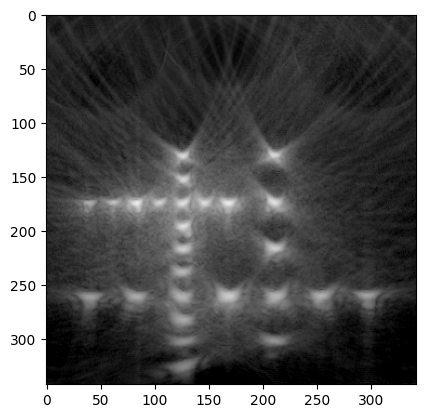

In [56]:
plt.imshow(image, cmap='gray', vmin=-100, vmax=-50)

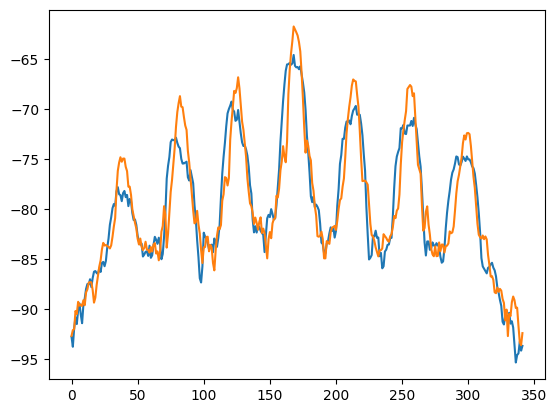

In [54]:
plt.plot(image1[257]) # sequential
plt.plot(image2[257]-3) # synchronous